In [457]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt 
import random
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\abhis\Downloads\windows_10_cmake_Release_Graphviz-12.0.0-win64\Graphviz-12.0.0-win64\bin"

In [458]:
def f(x):
    return 3*x**2 -4*x +5

In [459]:
f(3.0)

20.0

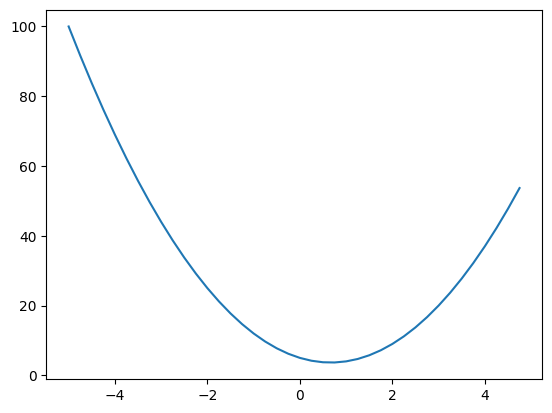

In [460]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [461]:
h=0.000001
x=2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [462]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [463]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self): #topological sort 
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [464]:
a = Value(2.0, label='a')
b = Value(-4.0, label='b')


In [465]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [466]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


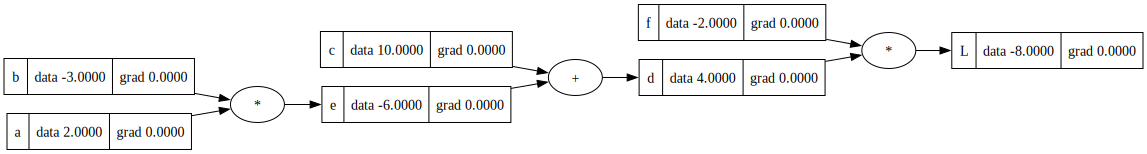

In [467]:
draw_dot(L)

In [468]:
def lol():
   
  h=0.001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1=L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data+=h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2=L.data
  
  print((L2-L1)/h)
  
lol()  

-3.9999999999995595


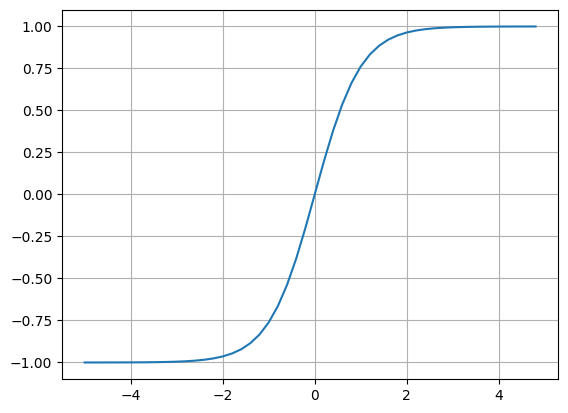

In [469]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [470]:
#inputs 
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias of the neuron
b=Value(6.88,label='b')
#x1w1+x2w2+b
x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2+b;n.label='n'
#output 
o=n.tanh()
o.label='o'

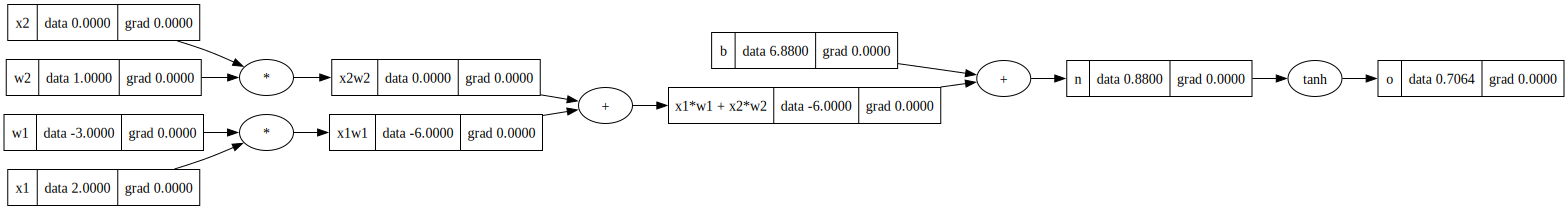

In [471]:
draw_dot(o)

In [472]:
o.backward()

In [473]:
# o.grad=1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [474]:
# n.grad=0.5
# b.grad=0.5
# x1w1x2w2.grad=0.5
# x2w2.grad=0.5
# x1w1.grad=0.5
# b.grad=0.5
# x2.grad=0.5
# w2.grad=0.0
# w1.grad=1.0
# x1.grad=-1.5

In [475]:
o.grad=1.0

In [476]:
1-o.data**2

0.5009717437695084

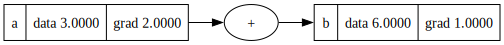

In [477]:
a=Value(3.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)

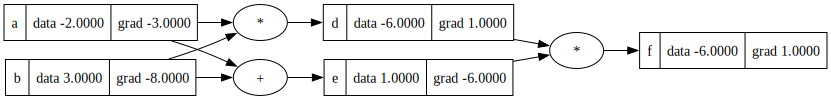

In [478]:
a=Value(-2.0,label='a')
b=Value(3.0,label='b')
d=a*b ; d.label='d'
e=a+b ; e.label='e'
f=d*e ; f.label='f'

f.backward()
draw_dot(f)



In [479]:
x1=torch.tensor([2.0]).double() ; x1.requires_grad=True
x2=torch.tensor([0.0]).double() ; x2.requires_grad=True
w1=torch.tensor([-3.0]).double() ; w1.requires_grad=True
w2=torch.tensor([1.0]).double() ; w2.requires_grad=True
b=torch.tensor([6.881373]).double(); b.requires_grad=True
n=x1*w1 + x2*w2 + b
o=torch.tanh(n)

print(o.data.item())
print(o.backward())

print('---')
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())


0.7071064519863152
None
---
x1 -1.500001396677975
x2 0.500000465559325
w1 1.00000093111865
w2 0.0


In [516]:
class Neuron: 
    
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w * x +  b
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)  
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] 
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)] #initialising the number(nout) of Neurons with number of imputs(nin) 

    def __call__(self,x):
        out=[n(x) for n in self.neurons] #putting the values of inputs in each Neuron initialized 
        return out[0] if len(out)==1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params=[]
        # for neuron in self.neurons:
        #   params.extend(neuron.parameters())
        # return params  

class MLP:          
       
    def __init__(self,nin,nouts):
        sz=[nin]+nouts    # nouts is 1d array where each element in array contains size of each layer
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]  #initializing layer
    
    def __call__(self,x):
      for layer in self.layers:  
          x=layer(x)
      return x 
     
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] #[[[..],[...]],[[..],[...]],[[..],[...]]]
      



In [518]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)         

Value(data=0.49157616913271573)

In [519]:
n.parameters()

[Value(data=0.22412986243488753),
 Value(data=0.7939027778474432),
 Value(data=-0.03410483576346057),
 Value(data=-0.40550584227835595),
 Value(data=0.8370718917000319),
 Value(data=-0.3659181771080895),
 Value(data=0.6878349134678119),
 Value(data=-0.5167815125233368),
 Value(data=-0.7227778578791786),
 Value(data=-0.007512800935057129),
 Value(data=0.3326454302125137),
 Value(data=0.29321462598673254),
 Value(data=-0.9945941546531218),
 Value(data=0.11997794224212077),
 Value(data=-0.43248456389047973),
 Value(data=-0.5799495790064606),
 Value(data=0.6455429842544846),
 Value(data=0.5353264093215946),
 Value(data=-0.017685107337438888),
 Value(data=-0.6130388070940094),
 Value(data=-0.48515138922196277),
 Value(data=-0.2646486657324685),
 Value(data=-0.6580301423650163),
 Value(data=-0.8164262533488602),
 Value(data=-0.6372141603302359),
 Value(data=0.1644630962650493),
 Value(data=-0.011746467587612885),
 Value(data=-0.9909273852598897),
 Value(data=-0.10866699722503581),
 Value(dat

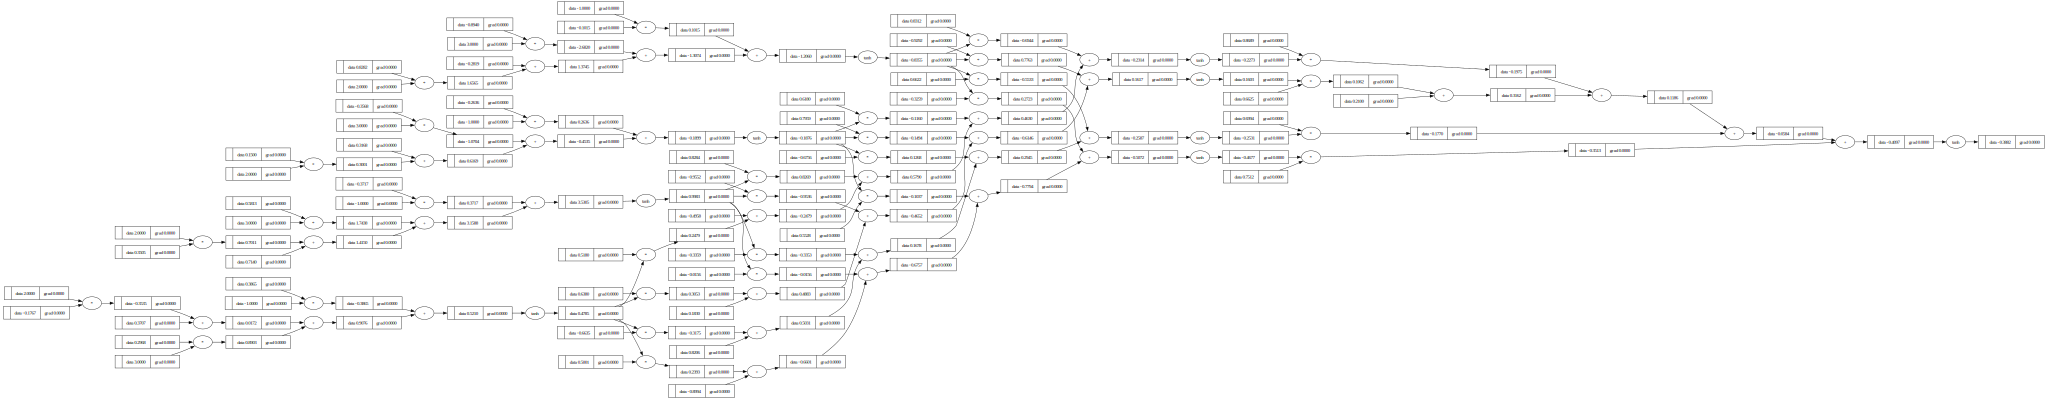

In [500]:
draw_dot(n(x))

In [512]:
xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]]
ys=[1.0,-1.0,-1.0,1.0] #desired targets
ypred=[n(x) for x in xs]
ypred

[Value(data=-0.38824640636064844),
 Value(data=0.3683406752387653),
 Value(data=-0.18035271761703842),
 Value(data=0.03786182314125987)]

In [504]:
loss=sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=5.39711582717297)

In [505]:
loss.backward()

In [507]:
n.layers[0].neurons[0].w[0].grad

-1.9608894245755037

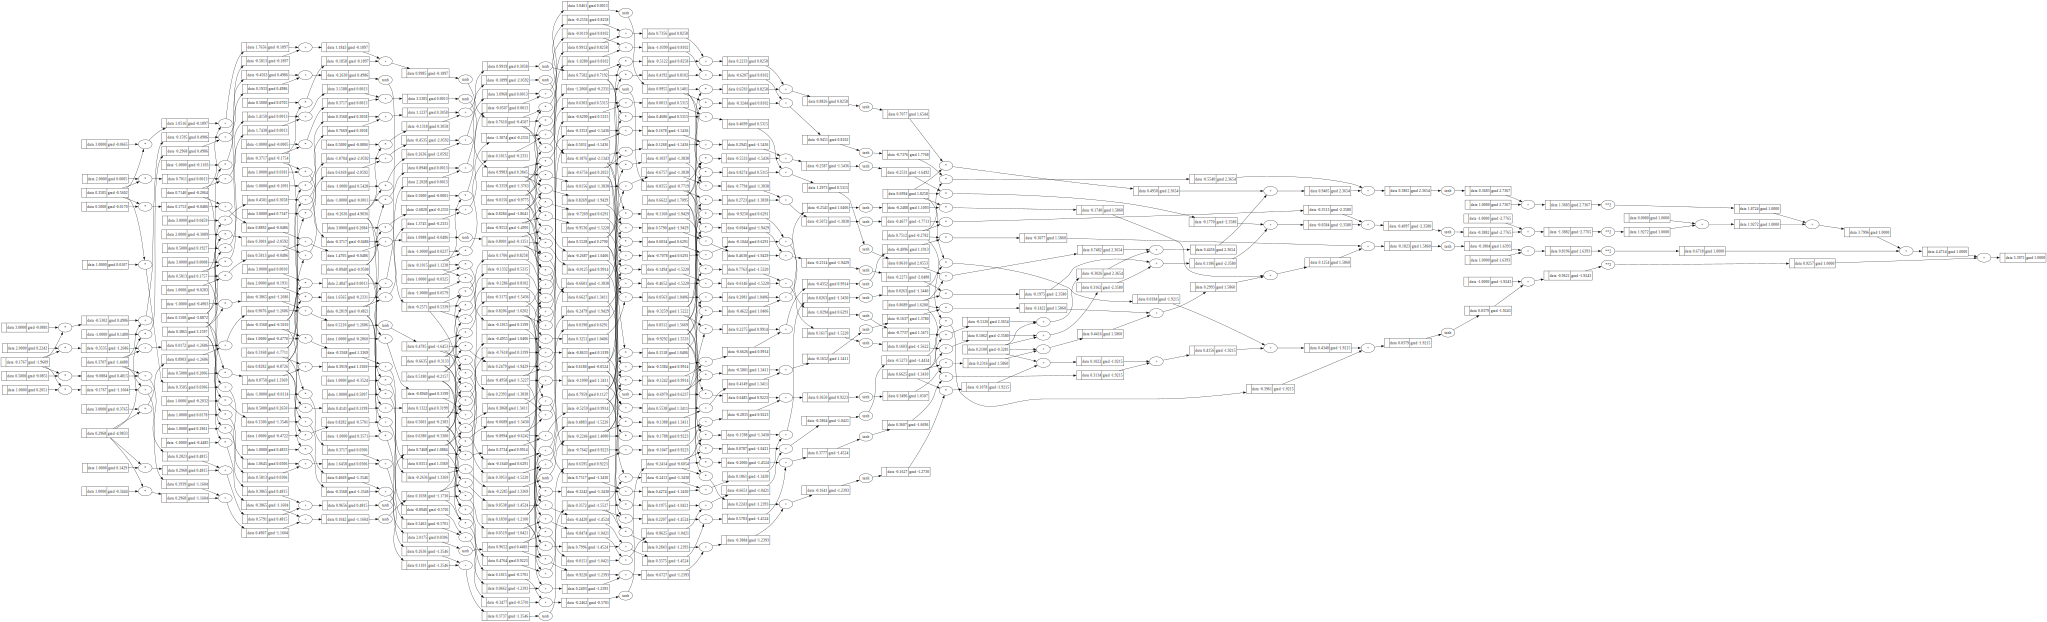

In [508]:
draw_dot(loss)

In [521]:
for k in range(20):
    
    #forward pass
    ypred=[n(x) for x in xs]
    loss=sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    
     #update
    for p in n.parameters():
        p.data+=-0.05*p.grad
        
    print(k,loss.data)

0 0.04382062692498617
1 0.041337155332216505
2 0.03910841801548634
3 0.03709773700729558
4 0.03527509988396813
5 0.033615717833801385
6 0.03209894155791332
7 0.030707435684208313
8 0.029426542645956837
9 0.028243787256036466
10 0.02714848702897935
11 0.026131442871778182
12 0.025184691485742185
13 0.02430130560639195
14 0.02347523165683692
15 0.02270115690418168
16 0.021974400061136663
17 0.021290820653906917
18 0.020646743513375403
19 0.02003889553174066


In [522]:
ypred

[Value(data=0.9265614851032006),
 Value(data=-0.9323068002456857),
 Value(data=-0.9412129661974735),
 Value(data=0.9187141130009868)]